In [43]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [44]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
tau_x_1 = False
N = 8
model_type = 'best'
extra_name = ''
if tau_x_1:
    extra_name = '_tau_x_1'
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [45]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.quantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#N, use_jet_pt, use_jet_mass are taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr'
# save details whether you want to save it or not
def make_graphs(model_copy, N, use_jet_pt, use_jet_mass, tau_x_1, test_set, part_dataset, zero_bias=False, lrp_type='zero', lrp_param=None,
               graphs=['abs_bar', 'bar', 'dist', 'corr'], figsize=(10, 10), options = '', extra_name=False, save=False):
    options = options if options else 'baseline'
    if extra_name:
        if zero_bias:
            options += '_zero_bias'
        if lrp_type == 'gamma':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'epsilon':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'zero':
            options += '_LRP-' + lrp_type
        
    classes = []
    if not tau_x_1:
        for i in range(N-1):
            if i != N-2:
                classes.append('tau_'+str(i+1)+'_'+str(0.5))
                classes.append('tau_'+str(i+1)+'_'+str(1))
                classes.append('tau_'+str(i+1)+'_'+str(2))
            else:
                classes.append('tau_'+str(i+1)+'_'+str(1))
                classes.append('tau_'+str(i+1)+'_'+str(2))
        if use_jet_pt:
            classes.append('jet_pt')
        if use_jet_mass:
            classes.append('jet_mass')
    else:
        for i in range(N-1):
            classes.append('tau_'+str(i+1)+'_'+str(1))
        if use_jet_pt:
            classes.append('jet_pt')
        if use_jet_mass:
            classes.append('jet_mass')
    layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
          'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
    data,labels = test_set[:]
    full_data = np.concatenate((data,labels),axis=1)
    df_test = pd.DataFrame(full_data, columns=np.append(classes, ['background_prob', 'signal_prob']))
    if part_dataset == 'sig':
        part_data = df_test.loc[df_test['signal_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
        col=1
    elif part_dataset == 'bkg':
        part_data = df_test.loc[df_test['background_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
        col=0
    if  'average_feats' in options:
        part_data = df_test.drop(columns=['background_prob', 'signal_prob'])
        part_data = part_data[part_data.columns].mean()*(part_data[part_data.columns] + 1.e-9)/(part_data[part_data.columns] + 1.e-9)
        part_data = part_data.to_numpy()
    L=14 #num layers
    A = [torch.from_numpy(part_data).float().cuda()]+[None]*L
    for i in range(L):
        A[i+1] = model_copy._modules[layer_names[i]].forward(A[i])
    def newlayer(layer,g):
        layer = copy.deepcopy(layer)
        with torch.no_grad():
            try: layer.weight = nn.Parameter(g(layer.weight))
            except AttributeError: pass
            if zero_bias:
                try: nn.init.constant_(layer.bias, 0.0)
                except AttributeError: pass
            else:
                try: layer.bias   = nn.Parameter(g(layer.bias))
                except AttributeError: pass
        return layer
    #Combine Dense+Activation functions
    #A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
    B = [A[0], A[3], A[6], A[9], A[12], A[13][:,col][...,None]]
    # Backpropagate relevance scores
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
    R = [None]*5 + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0,5)[::-1]:    
        #B[l] = (B[l+1].data).requires_grad_(True)
        B[l] = (B[l].data).requires_grad_(True)
        z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
        if l != 4:
            z = model_copy._modules[layer_names[3*l+1]].forward(z)
            z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
        else:
            z = incr(z[:,col][...,None])
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R[l+1].clone())
        R2_sum_nz = torch.sum(R[l+1][inds_nz].clone())
        R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([1]).cuda(), z)
        R[l + 1] = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([0]).cuda(), R[l+1])

        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R[l] = (B[l]*c).data                                   # step 4
    
    #Plots relevances as normalized
    R[0] = R[0].detach().cpu()
    normal_rel = np.empty_like(R[0])
    #Normalizes relevances for each sample
    normal_rel = (R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]).detach().numpy()
    if part_dataset == 'sig': 
        type_set = 'Signal'
    else: 
        type_set = 'Background'
    idx=0
    if 'abs_bar' in graphs:
        print('abs_bar')
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Relevance Score", fontsize=10)
        if  'average_feats' in options:
            plt.xlabel("|Mean-Behavior Relevance Score|", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body Absolute Value "+type_set+" LRP values")
        idx+=1
        if save:
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_absbar"+options+".png", 
            #            dpi = 150, bbox_inches='tight')
            plt.savefig("figures/LRP_MB8S_{}_{}_absbar.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Mean |Relevance Score|", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body "+type_set+" LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_bar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'dist' in  graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        shap.summary_plot(normal_rel_no_outlier, sig, feature_names=classes, max_display = 10, plot_type = "dot", show=False)
        #plt.title("Multi-Body "+type_set+" LRP values")
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_dist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'corr' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=(10,10))
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes)
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        #plt.title("Multi-Body "+type_set+" LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/LRP_MB8S_{}_{}_LRPcorr.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'feature_corr' in graphs:
        plt.figure(idx, figsize=(10,10))
        df_rel_total = pd.DataFrame(part_data, columns=classes)
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        #plt.title("Multi-Body "+type_set+" Feature Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_feature_corr"+options+".png", dpi = 150, bbox_inches='tight')
            plt.savefig("figures/LRP_MB8S_{}_{}_featcorr.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'box_whisker' in graphs:
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(removeOutliers(normal_rel), columns=classes)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("Multi-Body "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_box_whisker"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 
   
    #Combine Dense+Activation functions
    #A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
    B = [A[0], A[3], A[6], A[9], A[12], A[13][:,1-col][...,None]]
    # Backpropagate relevance scores
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
    R_ = [None]*5 + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0,5)[::-1]:    
        B[l] = (B[l].data).requires_grad_(True)

        z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
        if l != 4:
            z = model_copy._modules[layer_names[3*l+1]].forward(z)
            z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
        else:
            z = incr(z[:,1-col][...,None])
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R_[l+1].clone())
        R2_sum_nz = torch.sum(R_[l+1][inds_nz].clone())
        R_[l+1] = R_[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([1]).cuda(), z)
        R_[l + 1] = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([0]).cuda(), R_[l+1])

        s = (R_[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R_[l] = (B[l]*c).data                                   # step 4
    R_[0] = R_[0].detach().cpu()    
    #Plots relevances as normalized
    #Normalizes difference in relevances using pre-sigmoid output
    normal_rel = ((R[0]-R_[0])/(A[13][:,col][...,None].cpu()-A[13][:,1-col][...,None].cpu())).detach().numpy()
    #maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
    #normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
    
    if 'diff_abs_bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Relevance Score")
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body Absolute Value "+type_set+" Difference LRP values")
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_diff_absbar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Relevance Score")
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body "+type_set+" Difference LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_diff_bar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_dist' in  graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        shap.summary_plot(normal_rel_no_outlier, sig, feature_names=classes, max_display = 10, plot_type = "dot", show=False)
        #plt.title("Multi-Body "+type_set+" Difference LRP values")
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_diff_dist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_corr' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes)
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        #plt.title("Multi-Body "+type_set+" Difference LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_diff_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_box_whisker' in graphs:
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(removeOutliers(normal_rel), columns=classes)
        sorted_index = df_rel_total.mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("Multi-Body "+type_set+" Difference LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_diff_box_whisker"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 

    print("Not applicable graph type")
    return


abs_bar


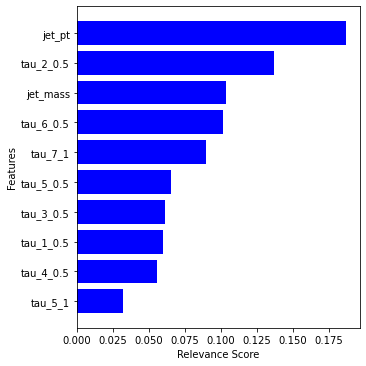

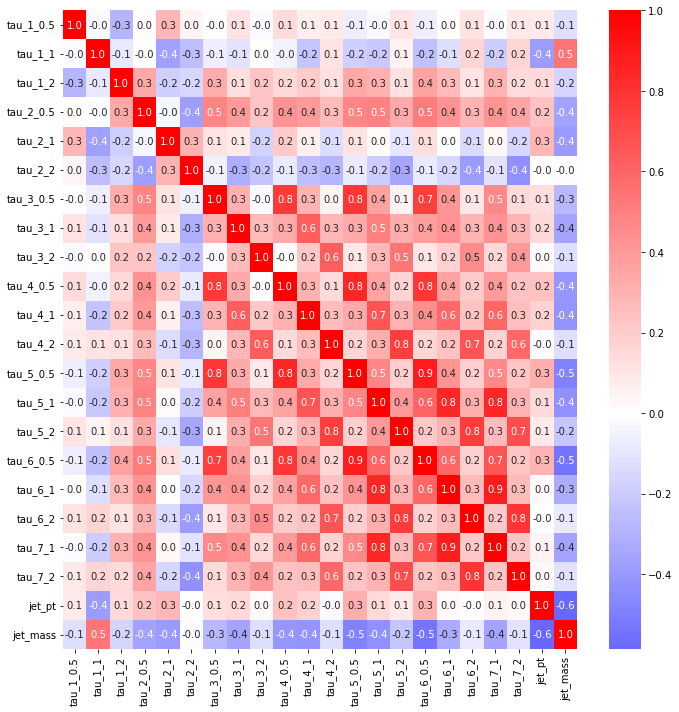

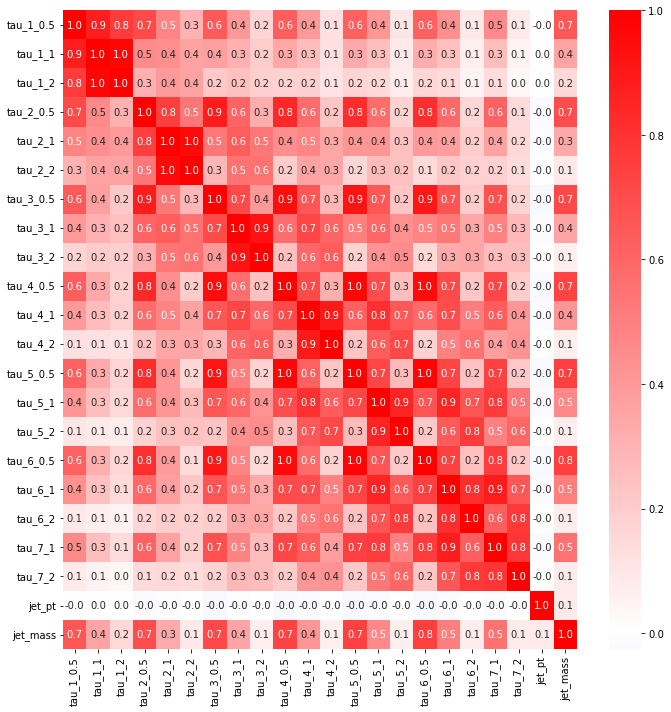

abs_bar


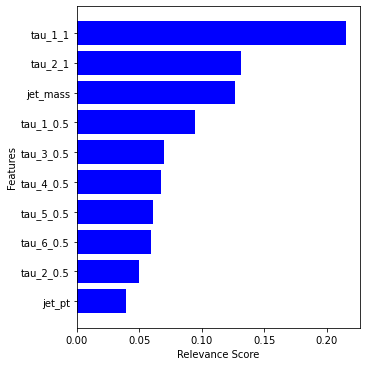

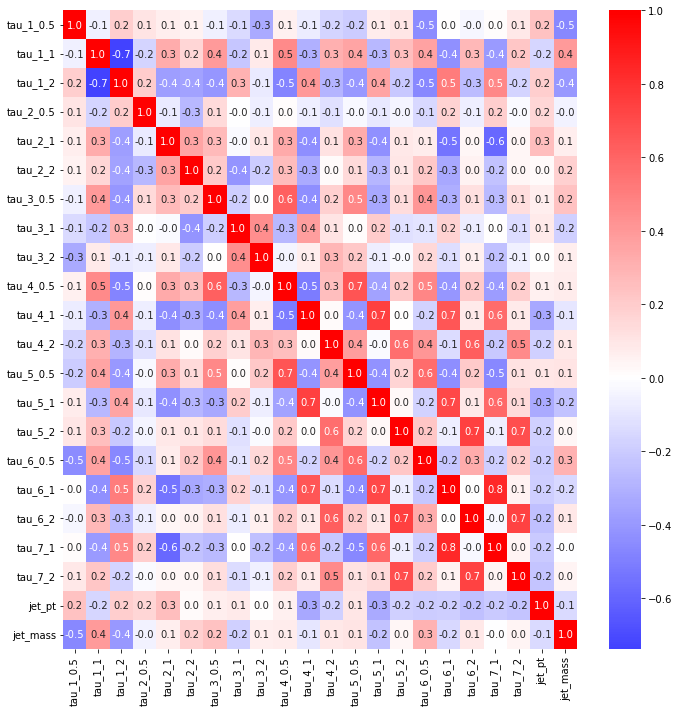

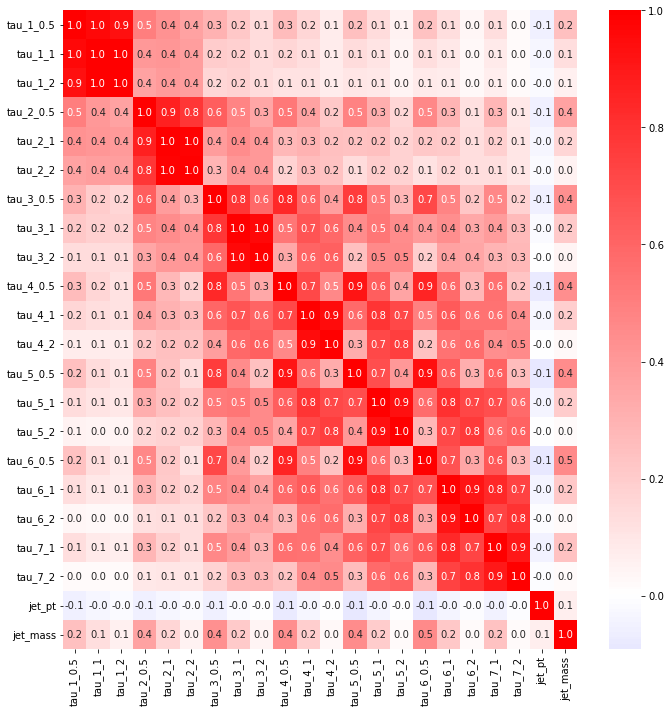

In [46]:
#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#N, use_jet_pt, use_jet_mass are taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr','box_whisker', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr','diff_box_whisker'
# The ones beggining in diff detail the difference in relevance values of the background/signal output for the part_dataset
# save details whether you want to save it or not
#figsize is the figure size of all plots, options are extra names you can add to end of saved figure 
#when specifying options, suggested to put '_' before the word
#extra_name specifies what LRP type automatically when saving
part_dataset = 'sig'
zero_bias=False
lrp_type='gamma'
lrp_param=4
graphs=['abs_bar', 'feature_corr', 'corr']
figsize=(5,5)
options = ('pt' if use_jet_pt else '') + ('mass' if use_jet_mass else '') + ('_' + extra_name if extra_name else '')
save=True
extra_name=False
for sigtype in ['bkg','sig']:
    total = make_graphs(model_copy=model, N=N, use_jet_pt=use_jet_pt, 
                        use_jet_mass=use_jet_mass, tau_x_1=tau_x_1, 
                        test_set=test_set, part_dataset=sigtype,
                        zero_bias=zero_bias, lrp_type=lrp_type, 
                        lrp_param=lrp_param, graphs=graphs,
                        figsize=figsize, options=options, 
                        extra_name=extra_name, save=save)

abs_bar


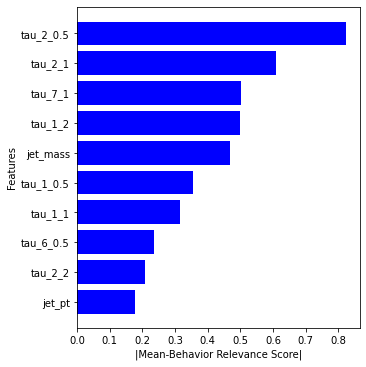

abs_bar


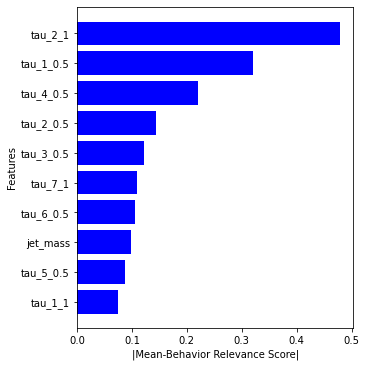

In [47]:
for sigtype in ['bkg','sig']:
    total = make_graphs(model_copy=model, N=N, use_jet_pt=use_jet_pt, 
                        use_jet_mass=use_jet_mass, tau_x_1=tau_x_1, 
                        test_set=test_set, part_dataset=sigtype,
                        zero_bias=zero_bias, lrp_type=lrp_type, 
                        lrp_param=lrp_param, graphs=['abs_bar'],
                        figsize=figsize, options=options + '_average_feats', 
                        extra_name=extra_name, save=save)

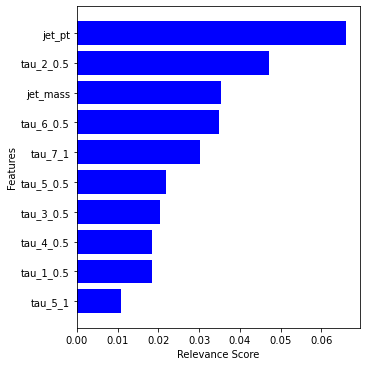

In [42]:
total = make_graphs(model_copy=model, N=N, use_jet_pt=use_jet_pt, 
                        use_jet_mass=use_jet_mass, tau_x_1=tau_x_1, 
                        test_set=test_set, part_dataset='bkg',
                        zero_bias=zero_bias, lrp_type=lrp_type, 
                        lrp_param=lrp_param, graphs=['diff_abs_bar'],
                        figsize=figsize, options=options, 
                        extra_name=extra_name, save=False)

In [124]:
arr = np.array([])
for i in range(22):
    arr = np.append(arr, len(total['fliers'][i].get_data()[0]))

In [127]:
total

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4094948d60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f40947fa340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4094948a90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f40947fa8e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f40947fabb0>,
 'means': []}

In [125]:
df['LRP_gamma_2'] = arr

In [126]:
df

,LRP_zero,LRP_eps_1e-7,LRP_gamma_1,LRP_gamma_2,LRP_gamma_4,LRP_gamma_10
0,27366.0,27372.0,14795.0,6880.0,2787.0,958.0
1,26797.0,26799.0,30659.0,23731.0,15518.0,5438.0
2,32957.0,32955.0,33658.0,30799.0,28569.0,26620.0
3,28640.0,28643.0,24275.0,15083.0,8864.0,5211.0
4,27856.0,27857.0,39246.0,26662.0,17454.0,9597.0
5,38646.0,38634.0,38962.0,31725.0,22015.0,16456.0
6,29288.0,29294.0,18920.0,11527.0,7777.0,6472.0
7,30416.0,30419.0,19575.0,12331.0,9284.0,8350.0
8,41145.0,41147.0,26590.0,22327.0,21346.0,21633.0
9,27205.0,27208.0,17687.0,9279.0,4256.0,1340.0


In [169]:
df[df.columns].sum()

LRP_zero        686540.0
LRP_eps_1e-7    686550.0
LRP_gamma_1     639189.0
LRP_gamma_2     477256.0
LRP_gamma_4     356753.0
LRP_gamma_10    287374.0
dtype: float64

In [3]:
#LRP options
zero_bias = False #Zeros bias
abs_relevance_score = True #Takes absolute value of relevances
epsilon = 1e-9
gamma = 2
#Can use LRP-gamma, LRP-epsilon, or LRP-zero, and it would be 'gamma' 'epsilon' or 'zero'
lrp_type = 'gamma'
options = ''
if zero_bias:
    options += '_zero_bias'
if abs_relevance_score:
    options += '_abs'
if lrp_type == 'gamma':
    options += '_LRP-' + lrp_type + '_' + str(gamma)
elif lrp_type == 'epsilon':
    options += '_LRP-' + lrp_type + '_' + str(epsilon)
elif lrp_type == 'zero':
    options += '_LRP-' + lrp_type

In [4]:
classes = []
for i in range(N-1):
    if i != N-2:
        classes.append('tau_'+str(i+1)+'_'+str(0.5))
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
    else:
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
if use_jet_pt:
    classes.append('jet_pt')
if use_jet_mass:
    classes.append('jet_mass')

In [5]:
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(classes, ['background_prob', 'signal_prob']))
sig = df_test.loc[df_test['signal_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A = [torch.from_numpy(sig)]+[None]*L
for i in range(L):
    A[i+1] = model._modules[layer_names[i]].forward(A[i])
print('done')

done


In [6]:
def newlayer(layer,g):

    layer = copy.deepcopy(layer)
    with torch.no_grad():
        try: layer.weight = nn.Parameter(g(layer.weight))
        except AttributeError: pass
        
        if zero_bias:
            try: nn.init.constant_(layer.bias, 0.0)
            except AttributeError: pass
        else:
            try: layer.bias   = nn.Parameter(g(layer.bias))
            except AttributeError: pass

    return layer

In [7]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [8]:
#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A[0], A[3], A[6], A[9], A[12], A[13][:,1][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,1][...,None])
        
    inds_nz = z != 0
    R1_sum = torch.sum(R[l+1])
    R2_sum_nz = torch.sum(R[l+1][inds_nz].clone())
    R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R[l+1])
    
    s = (R[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R[l] = (B[l]*c).data                                   # step 4

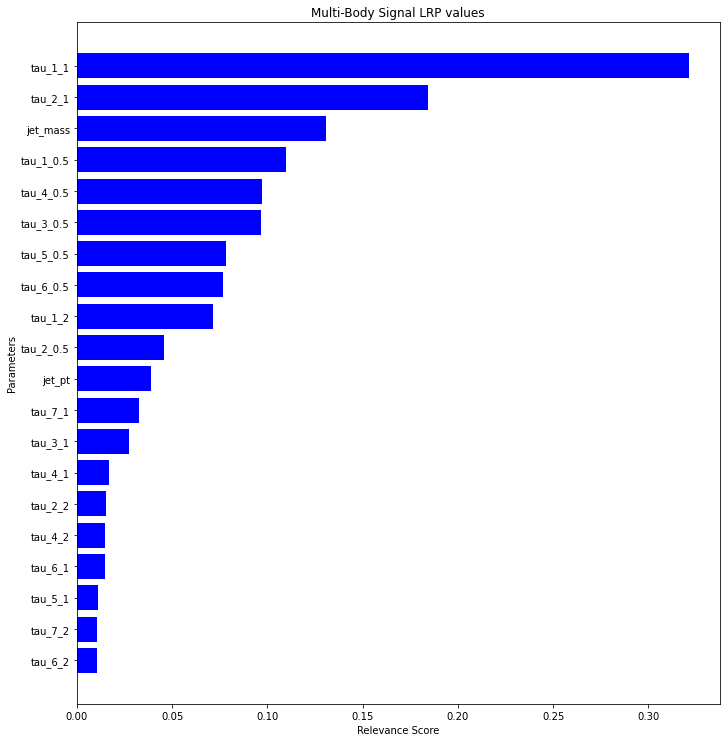

In [23]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Signal LRP values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_sig"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

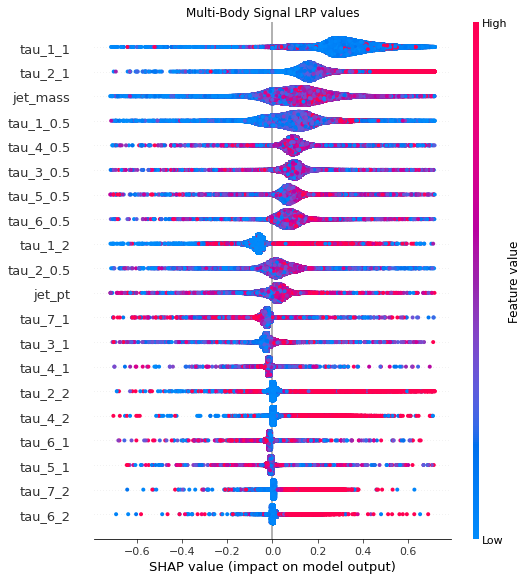

In [24]:
a = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Signal LRP values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_sig"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

<AxesSubplot:>

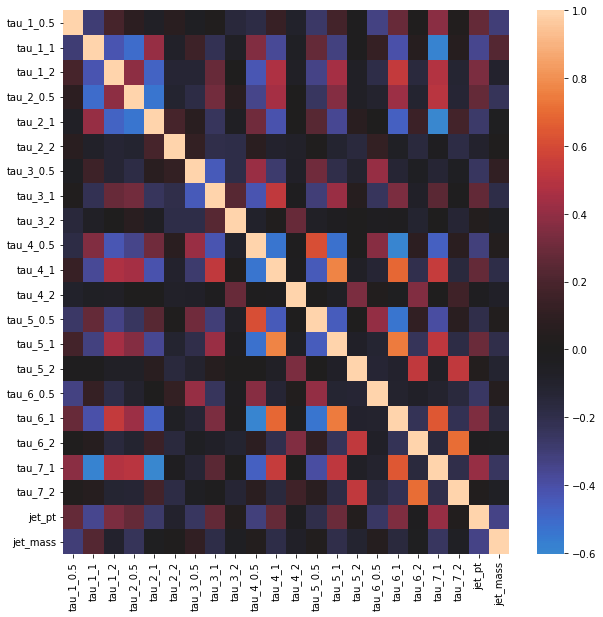

In [14]:
#Plots relevances as normalized and take absolute value
fig = plt.figure(figsize = (10, 10))
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
df = pd.DataFrame(normal_rel, columns=classes)
sns.heatmap(df.corr(), center=0)

In [202]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A[0], A[3], A[6], A[9], A[12], A[13][:,0][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R1 = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,0][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R1[l+1].clone())
    R2_sum_nz = sum(R1[l+1][inds_nz].clone())
    R1[l+1] = R1[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R1[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R1[l+1])
    
    s = (R1[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R1[l] = (B[l]*c).data                                   # step 4

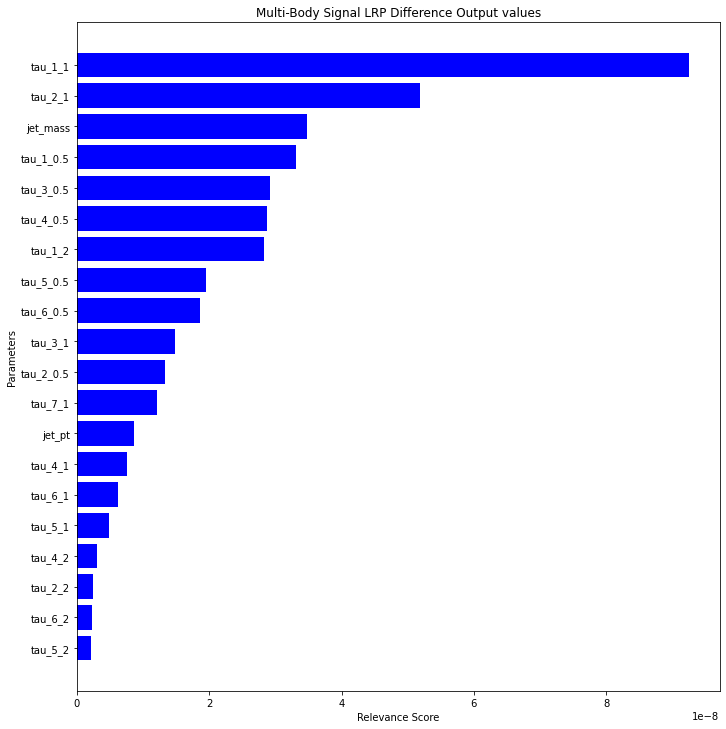

In [203]:
#Plots differences in LRP scores and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = (R[0]-R1[0])/(A[13][:,1][...,None]-A[13][:,0][...,None])
normal_rel = normal_rel.detach().numpy()
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Signal LRP Difference Output values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_sig"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

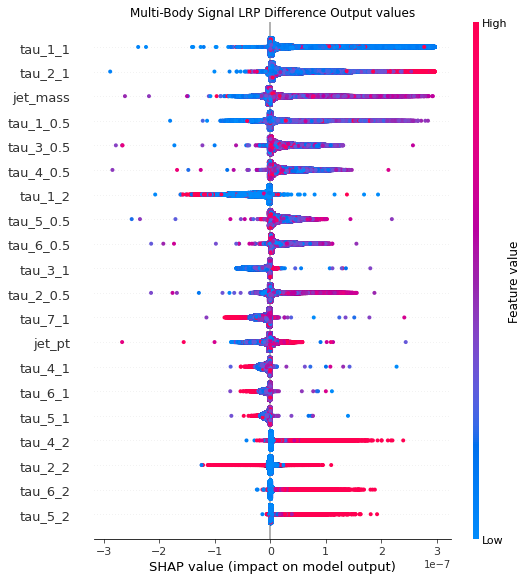

In [204]:
a = ((R[0]-R1[0])/(A[13][:,1][...,None]-A[13][:,0][...,None])).detach().numpy()
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Signal LRP Difference Output values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_sig"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [25]:
bkg = df_test.loc[df_test['background_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A_ = [torch.from_numpy(bkg)]+[None]*L
for i in range(L):
    A_[i+1] = model._modules[layer_names[i]].forward(A_[i])

#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [26]:
#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A_[0], A_[3], A_[6], A_[9], A_[12], A_[13][:,0][...,None]]
# Backpropagate relevance scores
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R_ = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,0][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R_[l+1].clone())
    R2_sum_nz = sum(R_[l+1][inds_nz].clone())
    R_[l+1] = R_[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R_[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R_[l+1])

    s = (R_[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R_[l] = (B[l]*c).data                                   # step 4

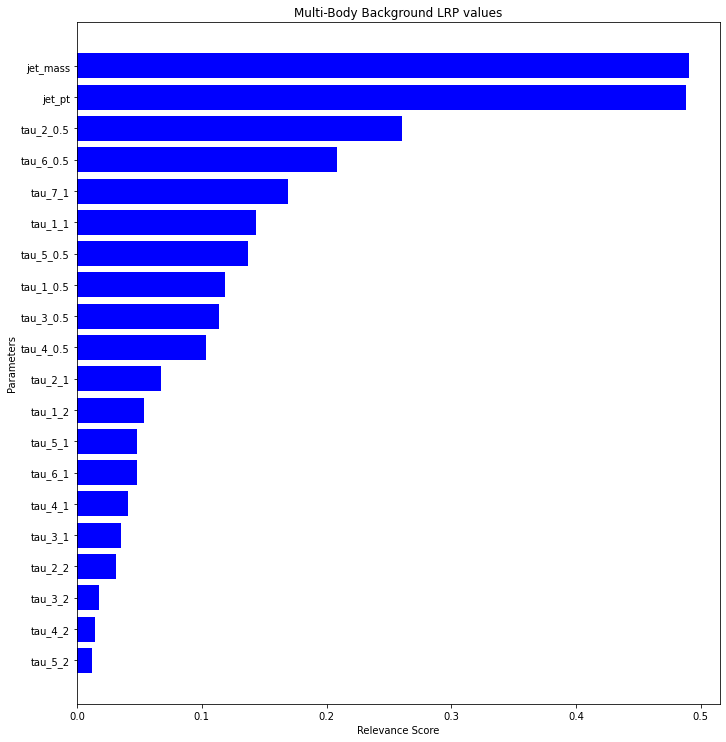

In [27]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R_[0])
#Normalizes relevances for each sample
normal_rel = R_[0]/np.sum(R_[0].detach().numpy(), 1)[:, np.newaxis]
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_bkg_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_bkg_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_bkg_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Background LRP values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_bkg"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

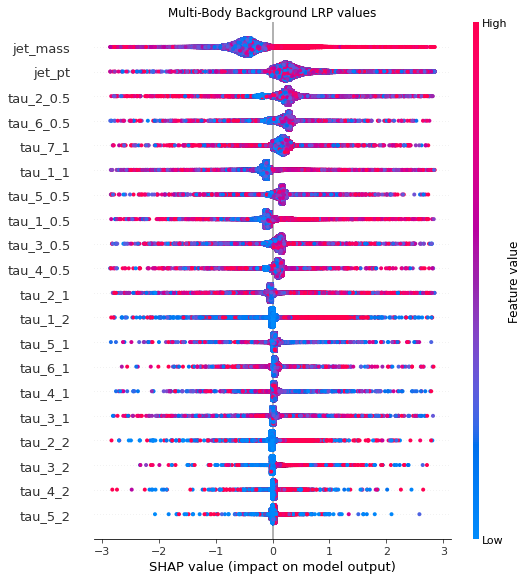

In [28]:
a = R_[0]/np.sum(R_[0].detach().numpy(), 1)[:, np.newaxis]
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, bkg, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Background LRP values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_bkg"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [209]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

#Combine Dense+Activation functions
#A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
B = [A_[0], A_[3], A_[6], A_[9], A_[12], A_[13][:,1][...,None]]
# Backpropagate relevance scores 
if lrp_type == 'zero':
    rho = lambda p: p;                       incr = lambda z: z
elif lrp_type == 'gamma':
    rho = lambda p: p + gamma*p.clamp(min=0); incr = lambda z: z
elif lrp_type == 'epsilon':
    rho = lambda p: p;                       incr = lambda z: z+epsilon
R_1 = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(z[:,1][...,None])
        
    inds_nz = z != 0
    R1_sum = sum(R_1[l+1].clone())
    R2_sum_nz = sum(R_1[l+1][inds_nz].clone())
    R_1[l+1] = R_1[l+1].clone()*R1_sum/R2_sum_nz
    z = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([1]), z)
    R_1[l + 1] = torch.where(z == torch.DoubleTensor([0]), torch.DoubleTensor([0]), R_1[l+1])

    s = (R_1[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R_1[l] = (B[l]*c).data                                   # step 4

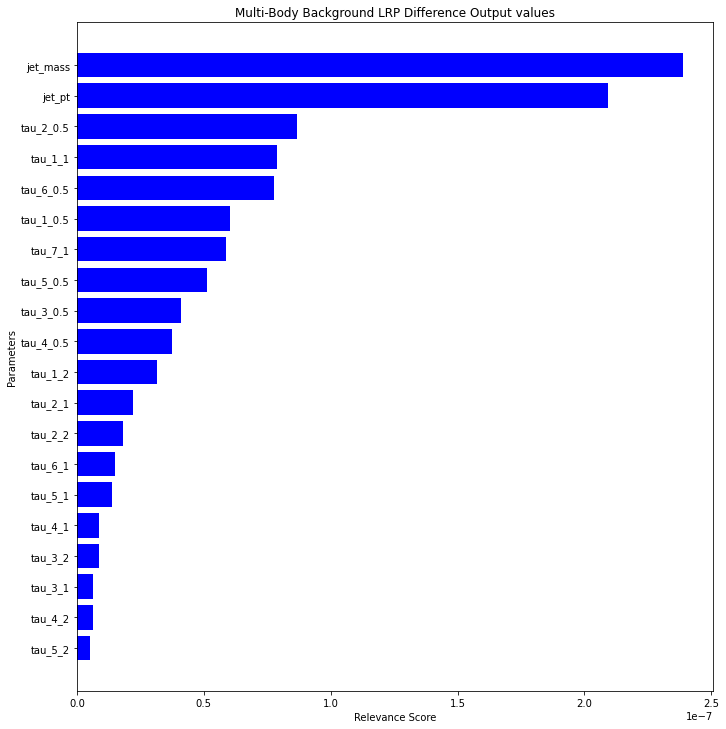

In [210]:
#Plots differences in LRP scores and take absolute value
normal_rel = np.empty_like(R_[0])
#Normalizes relevances for each sample
normal_rel = (R_[0]-R_1[0])/(A_[13][:,0][...,None]-A_[13][:,1][...,None])
normal_rel = normal_rel.detach().numpy()
maximum = np.sort(np.abs(normal_rel.flatten()))[-5000]
normal_rel = np.where(np.abs(normal_rel) < maximum, normal_rel, 0)
if abs_relevance_score: #Takes absolute value of relevance score if wanted
    normal_rel = np.abs(normal_rel)
relevances = np.nanmean(normal_rel, 0) #Takes mean across all jets
df_bkg_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_bkg_rel_sorted = df_bkg_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_bkg_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Background LRP Difference Output values")
#Saves plot
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_bkg"+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

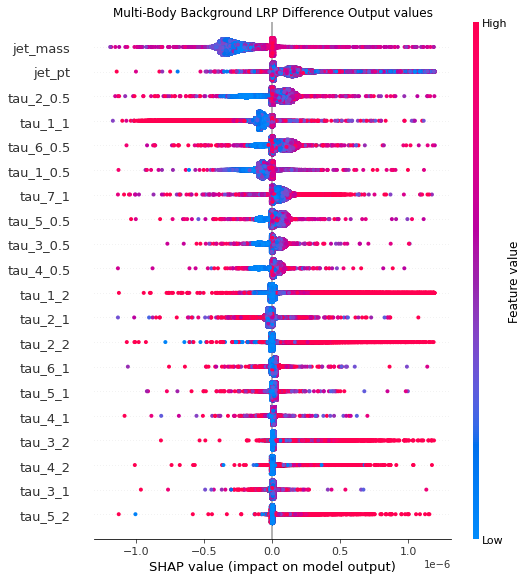

In [211]:
a = ((R_[0]-R_1[0])/(A_[13][:,0][...,None]-A_[13][:,1][...,None])).detach().numpy()
#maximum = np.sort(np.abs(a.flatten()))[-220028]
maximum = np.sort(np.abs(a.flatten()))[-5000]

scores = np.where(np.abs(a) < maximum, a, 0)
shap.summary_plot(scores, bkg, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
plt.title('Multi-Body Background LRP Difference Output values')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/diff_LRP_bkg"+options.replace('_abs', '')+"_dist.png", dpi = 150, bbox_inches='tight')
plt.show()

In [15]:
len(bkg)*5000/len(sig)

4995.800545929029